In [18]:
import pylab as pl
import scipy as sp
import numpy as np
from scipy.linalg import eig
from scipy.io import loadmat
import pdb

In [19]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    X,Y = data['X'],data['Y']
    # collapse the time-electrode dimensions
    X = sp.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = sp.sign((Y[0,:]>0) -.5)
    return X,Y

In [20]:
X,Y = load_data('bcidata.mat')
print(X.shape)
print(Y.shape)

(310, 5322)
(5322,)


In [21]:
def train_ncc(X,Y):
    '''
    Train a nearest centroid classifier
    '''
    indexes_of_minus_class = np.where(Y == -1.)
    X_minus = X[:, indexes_of_minus_class].reshape(310, -1)
    X_plus = np.delete(X, indexes_of_minus_class, axis = 1)
    # return the weight vector, bias term
    mu_minus = np.mean(X_minus, axis = 1)
    mu_plus = np.mean(X_plus, axis = 1)
    w = (mu_plus - mu_minus).T
    b = 1/2 * (mu_plus.T.dot(mu_plus) - mu_minus.T.dot(mu_minus))
    return w,b


In [26]:
def train_lda(X,Y):
    '''
    Train a linear discriminant analysis classifier
    '''
    indexes_of_minus_class = np.where(Y == -1.)
    X_minus = X[:, indexes_of_minus_class].reshape(310, -1)
    X_plus = np.delete(X, indexes_of_minus_class, axis = 1)

    mu_minus = np.mean(X_minus, axis = 1)
    mu_plus = np.mean(X_plus, axis = 1)    
    difference = mu_plus - mu_minus
    S_b = difference.dot(difference.T)
    for_minus = X_minus - mu_minus[:, None]
    for_plus = X_plus - mu_plus[:, None]
    S_w = for_minus.dot(for_minus.T) + for_plus.dot(for_plus.T)
    # return the weight vector, bias term
    w = np.linalg.inv(S_w).dot(difference)
    b = (w.T.dot(mu_plus) + w.T.dot(mu_minus))/2
    return w, b

In [27]:
def compare_classifiers():
    '''
    compares nearest centroid classifier and linear discriminant analysis
    '''
    fname = 'bcidata.mat'
    X,Y = load_data(fname)

    permidx = sp.random.permutation(sp.arange(X.shape[-1]))
    trainpercent = 70.
    stopat = int(sp.floor(Y.shape[-1]*trainpercent/100.))
    #pdb.set_trace()
    
    X,Y,Xtest,Ytest = X[:,permidx[:stopat]],Y[permidx[:stopat]],X[:,permidx[stopat:]],Y[permidx[stopat:]]
    print(X.shape, Y.shape)
    w_ncc,b_ncc = train_ncc(X,Y)
    w_lda,b_lda = train_lda(X,Y)
    fig = pl.figure(figsize=(12,5))

    ax1 = fig.add_subplot(1,2,1)
    #pl.hold(True)
    ax1.hist(w_ncc.dot(Xtest[:,Ytest<0]))
    ax1.hist(w_ncc.dot(Xtest[:,Ytest>0]))
    ax1.set_xlabel('$w^{T}_{NCC}X$')
    ax1.legend(('non-target','target'))
    ax1.set_title("NCC Acc " + str(sp.sum(sp.sign(w_ncc.dot(Xtest)-b_ncc)==Ytest)*100/Xtest.shape[-1]) + "%")
    ax2 = fig.add_subplot(1,2,2)
    ax2.hist(w_lda.dot(Xtest[:,Ytest<0]))
    ax2.hist(w_lda.dot(Xtest[:,Ytest>0]))
    ax2.set_xlabel('$w^{T}_{LDA}X$')
    ax2.legend(('non-target','target'))
    ax2.set_title("LDA Acc " + str(sp.sum(sp.sign(w_lda.dot(Xtest)-b_lda)==Ytest)*100/Xtest.shape[-1]) + "%")
    pl.savefig('ncc-lda-comparison.pdf')


(310, 3725) (3725,)


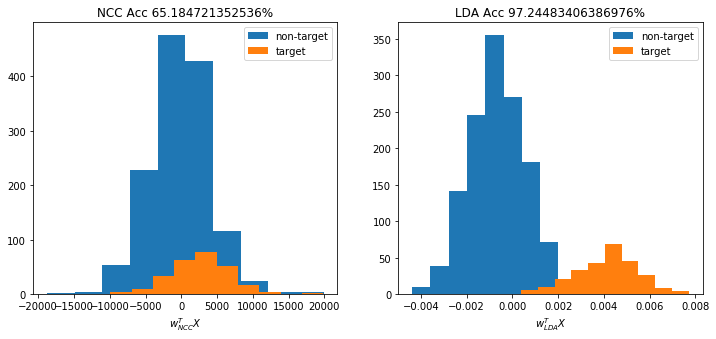

In [30]:
compare_classifiers()

In [46]:
def crossvalidate(X,Y,f=10,trainfunction=train_lda):
    ''' 
    Test generalization performance of a linear classifier
    Input:	X	data (dims-by-samples)
            Y	labels (1-by-samples)
            f	number of cross-validation folds
            trainfunction 	trains linear classifier
    '''
    total_number = list(range(len(Y)))
    l = int(len(total_number)/f) #length of each fold
    folds_list = []
    for i in range(f):
        folds_list += [total_number[i*l:(i+1)*l]]
        print(i*l, (i+1)*l)
    print(len(folds_list))
    acc_train = [None] * f
    acc_test = [None] * f
    for ifold in sp.arange(f):
        train = np.delete(total_number, folds_list[ifold])
        # train classifier
        Xtrain = X[:,train]
        Ytrain = Y[train]
        Xtest = X[:,folds_list[ifold]]
        Ytest = Y[folds_list[ifold]]
        w,b = trainfunction(Xtrain, Ytrain)
        # compute accuracy on training data
        acc_train[ifold] = sp.sum(sp.sign(w.dot(Xtrain)-b)==Ytrain)*100/Xtrain.shape[-1]
        # compute accuracy on test data
        acc_test[ifold] = sp.sum(sp.sign(w.dot(Xtest)-b)==Ytest)*100/Xtest.shape[-1]
    return acc_train,acc_test
    

In [47]:
X,Y = load_data('bcidata.mat')
crossvalidate(X,Y,f=10,trainfunction=train_lda)

0 532
532 1064
1064 1596
1596 2128
2128 2660
2660 3192
3192 3724
3724 4256
4256 4788
4788 5320
10


([98.01670146137788,
  97.93319415448852,
  98.18371607515658,
  98.07933194154488,
  97.78705636743216,
  97.95407098121086,
  97.82881002087683,
  97.84968684759916,
  97.89144050104385,
  97.78705636743216],
 [95.48872180451127,
  96.99248120300751,
  95.67669172932331,
  96.99248120300751,
  97.36842105263158,
  96.2406015037594,
  97.93233082706767,
  96.99248120300751,
  98.49624060150376,
  98.1203007518797])